In [1]:
!pip install czifile
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ud0utbsi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ud0utbsi
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=33ce163b59f5c680a4f1f4d4cb4a3dc4e028a9977aa171551c01e8a35781016c
  Stored in directory: /tmp/pip-ephem-wheel-cache-wruskvzp/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [3]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 92.2 MB/s eta 0:00:00


In [4]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [6]:
import torch
import torchvision
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import czifile
import sys
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from skimage.color import gray2rgb
from PIL import Image
from patchify import patchify, unpatchify
import cv2
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
from smooth_tiled_predictions import predict_img_with_smooth_windowing

In [7]:

filename = 'A1818_P0103_4MGLTumor_5.czi'
image = czifile.imread(filename)

I1 = image[0, :, :, 0]
I2 = image[1, :, :, 0]
I4 = image[3, :, :, 0]

# Normalize each channel to the range of 0-255
I1_normalized = (I1 - np.min(I1)) / (np.max(I1) - np.min(I1))
I1_normalized = (I1_normalized * 255).astype(np.uint8)

I2_normalized = (I2 - np.min(I2)) / (np.max(I2) - np.min(I2))
I2_normalized = (I2_normalized * 255).astype(np.uint8)

I4_normalized = (I4 - np.min(I4)) / (np.max(I4) - np.min(I4))
I4_normalized = (I4_normalized * 255).astype(np.uint8)

# Merge channels I1, I2, I4 into one image
merged_image1 = np.dstack((I1_normalized, I2_normalized, I4_normalized))
merged_image = (merged_image1 - np.min(merged_image1)) / (np.max(merged_image1) - np.min(merged_image1))
merged_image = (merged_image * 255).astype(np.uint8)

merged_image.shape

imagein = cv2.cvtColor(I1_normalized, cv2.COLOR_GRAY2RGB)

In [9]:
import numpy as np
from segment_anything import SamPredictor, sam_model_registry

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=10,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=50
)

# Create the predictor
predictor = SamPredictor(sam)

# CNN's receptive field's border size: size of patches
window_size = 230


# Load an image. Convention is channel_last, such as having an input_img.shape of: (x, y, nb_channels), where nb_channels is 3 for regular RGB images.
input_img = imagein

# Define the prediction function for the smooth windowing
def prediction_func(img_batch_subdiv):
    nb_patches = len(img_batch_subdiv)
    a = int(np.sqrt(nb_patches))
    b = nb_patches // a
    c, d, nb_channels = img_batch_subdiv[0].shape

    masks_all = []

    for patch in img_batch_subdiv:
        masks_old = mask_generator_.generate(patch)
        new_masks = []
        for mask_dict in masks_old:
            if mask_dict['area'] <= 1000:
                new_masks.append(mask_dict)

        masks = new_masks

        # Create a blank label image of the same size as the patch
        label_image = np.zeros_like(patch, dtype=np.uint8)

        # Assign a unique label to each mask
        for i, mask in enumerate(masks):
            segmentation_mask = mask['segmentation']
            label_image[segmentation_mask] = i + 1

        masks_all.append(label_image)

    masks_all = np.array(masks_all)

    return masks_all


# Use the algorithm with the Segment Anything model for prediction
predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=window_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=3,
    pred_func=prediction_func
)


100%|██████████| 8/8 [3:23:42<00:00, 1527.80s/it]


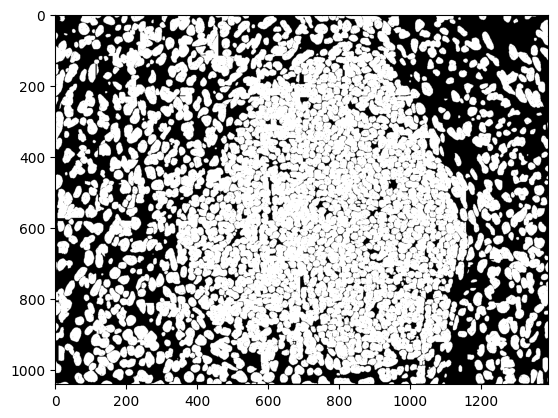

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert the predictions to uint8 data type
predictions_smooth_uint8 = (predictions_smooth * 255).astype(np.uint8)

# Convert the image to grayscale
gray_image = cv2.cvtColor(predictions_smooth_uint8, cv2.COLOR_BGR2GRAY)

# Threshold the grayscale image to create a binary mask
_, mask = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY)

# Save the binary mask
cv2.imwrite("mask.jpg", mask)

# Display the binary mask using plt.imshow()
plt.imshow(mask, cmap='gray')
plt.show()
